In [7]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df
from neuralforecast.models import Autoformer    

In [8]:
AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [9]:
Y_train_df.dtypes

unique_id            object
ds           datetime64[ns]
y                   float32
trend                 int64
y_[lag12]           float32
month               float64
dtype: object

In [10]:
Y_test_df

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1960-01-31,417.0,132,360.0,-0.500000
1,Airline1,1960-02-29,391.0,133,342.0,-0.409091
2,Airline1,1960-03-31,419.0,134,406.0,-0.318182
3,Airline1,1960-04-30,461.0,135,396.0,-0.227273
4,Airline1,1960-05-31,472.0,136,420.0,-0.136364
5,Airline1,1960-06-30,535.0,137,472.0,-0.045455
6,Airline1,1960-07-31,622.0,138,548.0,0.045455
7,Airline1,1960-08-31,606.0,139,559.0,0.136364
8,Airline1,1960-09-30,508.0,140,463.0,0.227273
9,Airline1,1960-10-31,461.0,141,407.0,0.318182


In [11]:
model = Autoformer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head=2,
                 loss=MAE(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=300,
                 val_check_steps=50,
                 early_stop_patience_steps=2)
nf = NeuralForecast(
    models=[model],
    freq='M'
)

Seed set to 1


In [12]:
nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s, v_num=166, train_loss_step=0.554, train_loss_epoch=0.554, valid_loss=15.40]


In [13]:
forecasts = nf.predict(futr_df=Y_test_df)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.86it/s]


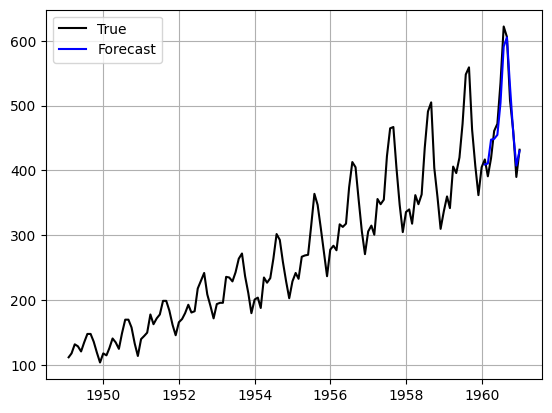

In [14]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Autoformer-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['Autoformer-lo-90'][-12:].values, 
                    y2=plot_df['Autoformer-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Autoformer'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()

In [15]:
#show tensorboard graphs
%load_ext tensorboard
%tensorboard --logdir lightning_logs/



Reusing TensorBoard on port 6006 (pid 107368), started 0:20:47 ago. (Use '!kill 107368' to kill it.)